In [1]:
import os
from pathlib import Path

# set current directory to TABME
if Path(os.getcwd()).stem!="TABME":
    os.chdir('..')

In [2]:
from utils.model import PDFSegmentationModel
from utils.config import config
from utils.dataset import TABME
# from utils.visualise import plot
import torch
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import json
import umap

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [3]:
# def plot(X, labels, predictions, title='Untitled plot', display_arrow=True):
#     labels_cumsum = np.cumsum(labels)
#     cmap = cm.get_cmap('jet', max(labels_cumsum))

#     plt.figure(figsize=(10, 10))
#     x_min, x_max = np.min(X, 0), np.max(X, 0)
#     X = (X - x_min) / (x_max - x_min)

#     if display_arrow:
#         plt.quiver(X[:-1, 0], X[:-1, 1], X[1:, 0]-X[:-1, 0], X[1:, 1]-X[:-1, 1], width=0.007, scale_units='xy', angles='xy', scale=1, color='0.8')
#     for i in range(X.shape[0]):
#         plt.scatter(X[i, 0], X[i, 1], color=cmap(labels_cumsum[i]))
#         text_color = 'k' if labels[i]==predictions[i] else 'r'
#         plt.text(X[i, 0]-0.04, X[i, 1]+0.02, f'{all_stems[i].split("-")[0]}', color=text_color, fontdict={'weight': 'bold', 'size': 9})

    
#     plt.xticks([]), plt.yticks([])
#     plt.xlim((-0.1,1.1)), plt.ylim((-0.1,1.1))
#     plt.title(title)
#     plt.show()

def plot(X, labels, predictions, title='Untitled plot', display_arrow=True, save_path=None):
    labels_cumsum = np.cumsum(labels)
    cmap = cm.get_cmap('jet', max(labels_cumsum))
    markers = ["o" , "v" , "^" , "<", ">", "s", "p", "h", "8", "P", "*", "d", "X"]

    plt.figure(figsize=(10, 10))
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if display_arrow:
        plt.quiver(X[:-1, 0], X[:-1, 1], X[1:, 0]-X[:-1, 0], X[1:, 1]-X[:-1, 1], width=0.007, scale_units='xy', angles='xy', scale=1, color='0.8')
    for i in range(X.shape[0]):
        # plt.scatter(X[i, 0], X[i, 1], color='gray', marker=markers[labels_cumsum[i]], s=100)
        plt.scatter(X[i, 0], X[i, 1], color=cmap(labels_cumsum[i]), marker=markers[labels_cumsum[i]], s=500)
        text_color = 'k' if labels[i]==predictions[i] else 'r'
        plt.text(X[i, 0]-0.1, X[i, 1]+0.04, r'\textbf{{{}}}'.format(all_stems[i].split("-")[0]), color=text_color, fontdict={'size': 20})

    
    plt.xticks([]), plt.yticks([])
    plt.xlim((-0.1,1.1)), plt.ylim((-0.1,1.1))
    plt.title(r"\textbf{{{}}}".format(title), fontdict={'size': 30})
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        
    plt.show()

# **Correct predictions**
## 1. Get feature vector from model

In [4]:
folder_id = 2

path_model_folder = 'output/model_weights/20220720-203907_l_5e-05_n_5_a_None'
path_data = 'data/test'
path_cache_folder = 'cache'
path_csv= 'predictions/full_model_predictions_test.csv'

num_hidden_layer=3
spacing = int((1280-2)/(num_hidden_layer+1))
num_hidden_features = [2+spacing*(n+1) for n in reversed(range(num_hidden_layer))]

ablation=None
blank_ocr=None
blank_img=None
batch_size = 64

path_model_folder = Path(path_model_folder)

device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_str)
print("device:", device_str)

embeddings = {}
embeddings_untrained = {}

# config
input_img_size = config['input_img_size']
max_seq_length = config['max_seq_length']

test_dataset = TABME(path_data=path_data, path_cache_folder=path_cache_folder, max_seq_length=max_seq_length, input_img_size=input_img_size)
df = pd.read_csv(path_csv)
print("# test dataset:", len(test_dataset))

# model
path_model_config = path_model_folder/"model_config.json"
if path_model_config.exists():
    model_config = json.load(open(path_model_config, "r"))
    num_hidden_features = model_config["num_hidden_features"] 
    ablation = model_config["ablation"]

def f(trained: bool):
    def printnorm(self, input, output):
        if trained:
            embeddings[folder_id] = {
                'ocr': input[0],
                'img': input[1]
            }
        else: 
            embeddings_untrained[folder_id] = {
                'ocr': input[0],
                'img': input[1]
            }
    return printnorm

# load model weights
model = PDFSegmentationModel(num_hidden_features=num_hidden_features, pretrained_weights=False)
model.load_state_dict(torch.load(path_model_folder/"best"/"model_weights.pt", map_location=device))
model = model.to(device)
model.conv1dlayers.register_forward_hook(f(True))
model.eval()

model_untrained = PDFSegmentationModel(num_hidden_features=num_hidden_features, pretrained_weights=True)
model_untrained = model_untrained.to(device)
model_untrained.conv1dlayers.register_forward_hook(f(False))
model_untrained.eval()

df_folder = df[df.folder_id==folder_id]
stems = df_folder.stem.to_list()
def stem_to_index(stem):
    index = np.where(test_dataset.page_ids==stem)
    return index[0][0]
indices = map(stem_to_index, stems)


sampler = torch.utils.data.BatchSampler(indices, batch_size=batch_size, drop_last=False)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_sampler=sampler)

all_labels = []
all_logits = []
all_logits_untrained = []
all_stems = []

for dataset in dataloader:

    inputs, image, labels, stems = dataset
            
    input_ids = inputs['input_ids'].to(device)
    bbox = inputs['bbox'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    labels = labels.to(device)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, image=image)
        outputs_untrained = model_untrained(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, image=image)
   
    # the first index is always the cut point
    # labels[0]=1
    
    all_logits += [outputs]
    all_logits_untrained += [outputs_untrained]

    all_labels += [labels]
    all_stems += stems
    # break


device: cpu
Using cache at cache/cache_test_150.hdf5
# test dataset: 6237


Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing LayoutLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMModel: ['cls.predictions.transform.dense.weig

## 2. Embed the feature vectors

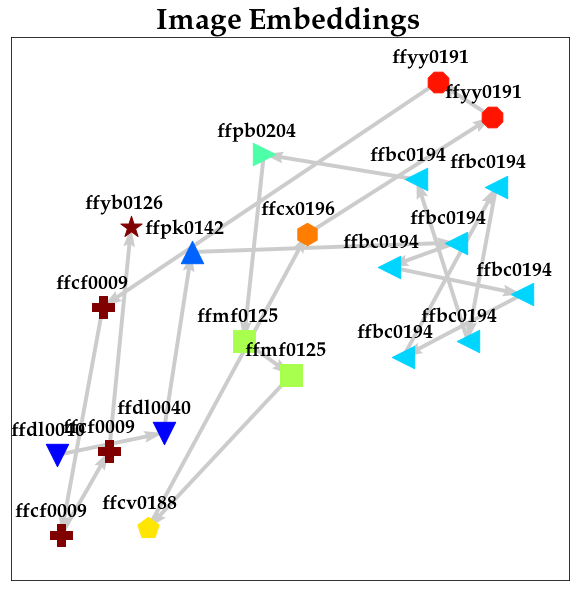

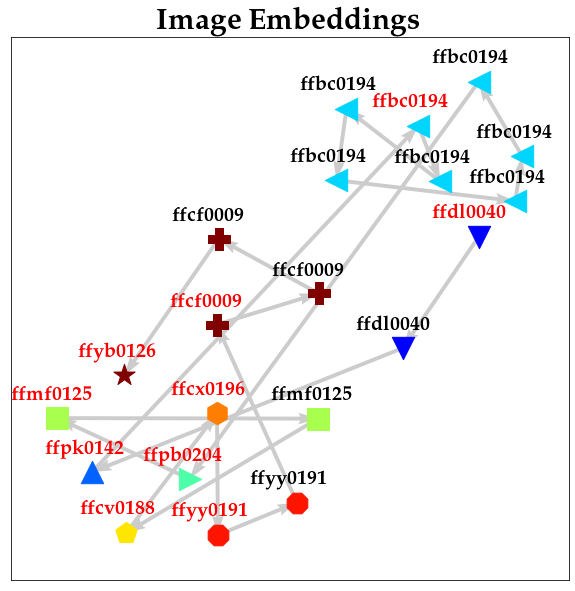

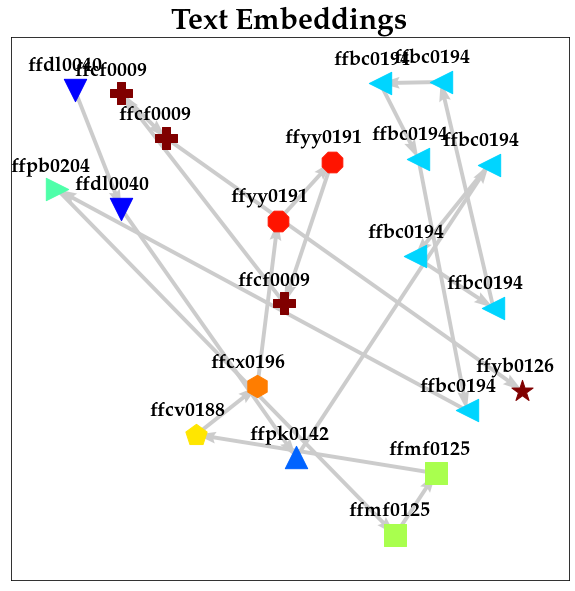

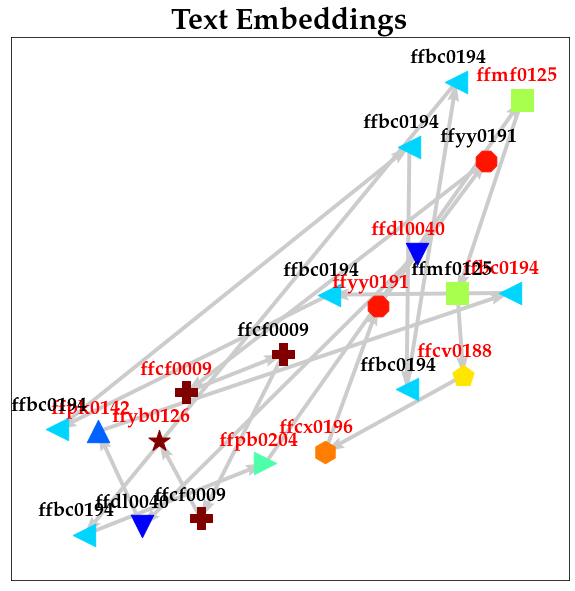

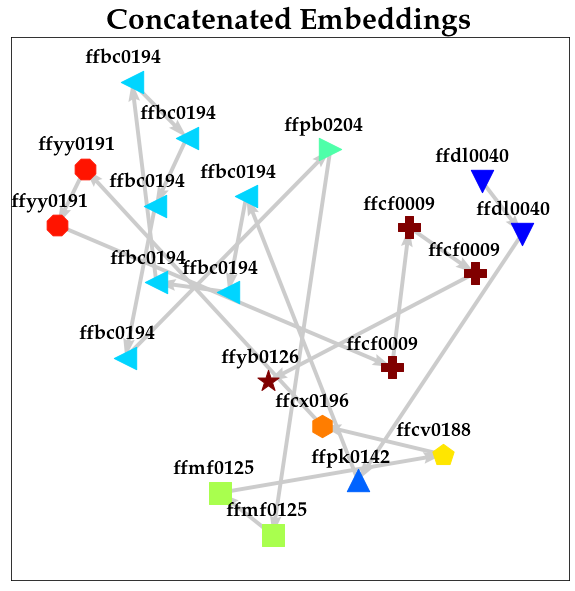

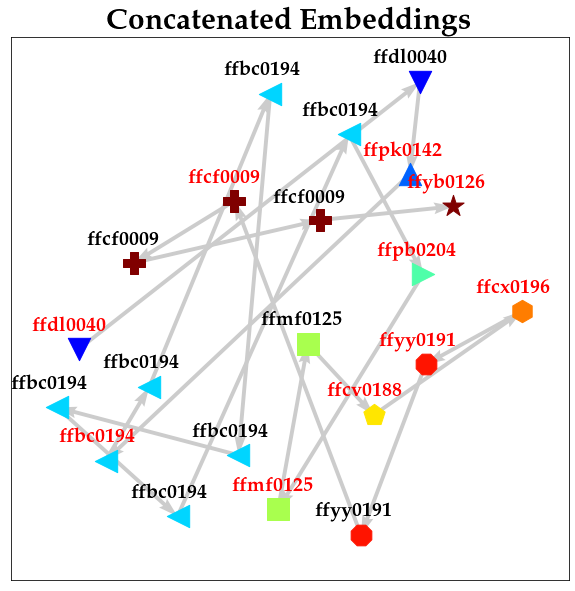

In [5]:
X_umap = umap.UMAP().fit_transform(embeddings[folder_id]['img'])
X_umap_untrained = umap.UMAP().fit_transform(embeddings_untrained[folder_id]['img'])

labels = np.array(all_labels[0])
predictions = np.argmax(outputs, axis=1)
plot(X_umap, labels, predictions, title=f"Image Embeddings", save_path="notebooks/figs/embed_img_train_correct.pdf")

predictions_untrained = np.argmax(outputs_untrained, axis=1)
plot(X_umap_untrained, labels, predictions_untrained, title= f"Image Embeddings", save_path="notebooks/figs/embed_img_untrain_correct.pdf")

X_umap = umap.UMAP().fit_transform(embeddings[folder_id]['ocr'])
X_umap_untrained = umap.UMAP().fit_transform(embeddings_untrained[folder_id]['ocr'])

labels = np.array(all_labels[0])
predictions = np.argmax(outputs, axis=1)
plot(X_umap, labels, predictions, title=f"Text Embeddings", save_path="notebooks/figs/embed_ocr_train_correct.pdf")

predictions_untrained = np.argmax(outputs_untrained, axis=1)
plot(X_umap_untrained, labels, predictions_untrained, title= f"Text Embeddings", save_path="notebooks/figs/embed_ocr_untrain_correct.pdf")

concat = torch.cat([embeddings[folder_id]['ocr'], embeddings[folder_id]['img']], 1)
concat_untrained = torch.cat([embeddings_untrained[folder_id]['ocr'], embeddings_untrained[folder_id]['img']], 1)
X_umap = umap.UMAP().fit_transform(concat)
X_umap_untrained = umap.UMAP().fit_transform(concat_untrained)

labels = np.array(all_labels[0])
predictions = np.argmax(outputs, axis=1)
plot(X_umap, labels, predictions, title=f"Concatenated Embeddings", save_path="notebooks/figs/embed_concat_train_correct.pdf")

predictions_untrained = np.argmax(outputs_untrained, axis=1)
plot(X_umap_untrained, labels, predictions_untrained, title= f"Concatenated Embeddings", save_path="notebooks/figs/embed_concat_untrain_correct.pdf")

# **Incorrect predictions**
## 1. Get feature vector from model

In [6]:
folder_id = 2526

path_model_folder = 'output/model_weights/20220720-203907_l_5e-05_n_5_a_None'
path_data = 'data/test'
path_cache_folder = 'cache'
path_csv= 'predictions/full_model_predictions_test.csv'

num_hidden_layer=3
spacing = int((1280-2)/(num_hidden_layer+1))
num_hidden_features = [2+spacing*(n+1) for n in reversed(range(num_hidden_layer))]

ablation=None
blank_ocr=None
blank_img=None
batch_size = 64

path_model_folder = Path(path_model_folder)

device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_str)
print("device:", device_str)

embeddings = {}
embeddings_untrained = {}

# config
input_img_size = config['input_img_size']
max_seq_length = config['max_seq_length']

test_dataset = TABME(path_data=path_data, path_cache_folder=path_cache_folder, max_seq_length=max_seq_length, input_img_size=input_img_size)
df = pd.read_csv(path_csv)
print("# test dataset:", len(test_dataset))

# model
path_model_config = path_model_folder/"model_config.json"
if path_model_config.exists():
    model_config = json.load(open(path_model_config, "r"))
    num_hidden_features = model_config["num_hidden_features"] 
    ablation = model_config["ablation"]

def f(trained: bool):
    def printnorm(self, input, output):
        if trained:
            embeddings[folder_id] = {
                'ocr': input[0],
                'img': input[1]
            }
        else: 
            embeddings_untrained[folder_id] = {
                'ocr': input[0],
                'img': input[1]
            }
    return printnorm

# load model weights
model = PDFSegmentationModel(num_hidden_features=num_hidden_features, pretrained_weights=False)
model.load_state_dict(torch.load(path_model_folder/"best"/"model_weights.pt", map_location=device))
model = model.to(device)
model.conv1dlayers.register_forward_hook(f(True))
model.eval()

model_untrained = PDFSegmentationModel(num_hidden_features=num_hidden_features, pretrained_weights=True)
model_untrained = model_untrained.to(device)
model_untrained.conv1dlayers.register_forward_hook(f(False))
model_untrained.eval()

df_folder = df[df.folder_id==folder_id]
stems = df_folder.stem.to_list()
def stem_to_index(stem):
    index = np.where(test_dataset.page_ids==stem)
    return index[0][0]
indices = map(stem_to_index, stems)


sampler = torch.utils.data.BatchSampler(indices, batch_size=batch_size, drop_last=False)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_sampler=sampler)

all_labels = []
all_logits = []
all_logits_untrained = []
all_stems = []

for dataset in dataloader:

    inputs, image, labels, stems = dataset
            
    input_ids = inputs['input_ids'].to(device)
    bbox = inputs['bbox'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    labels = labels.to(device)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, image=image)
        outputs_untrained = model_untrained(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, image=image)
   
    # the first index is always the cut point
    # labels[0]=1
    
    all_logits += [outputs]
    all_logits_untrained += [outputs_untrained]

    all_labels += [labels]
    all_stems += stems
    # break


device: cpu
Using cache at cache/cache_test_150.hdf5
# test dataset: 6237


Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing LayoutLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMModel: ['cls.predictions.transform.dense.weig

## 2. Embed the feature vectors

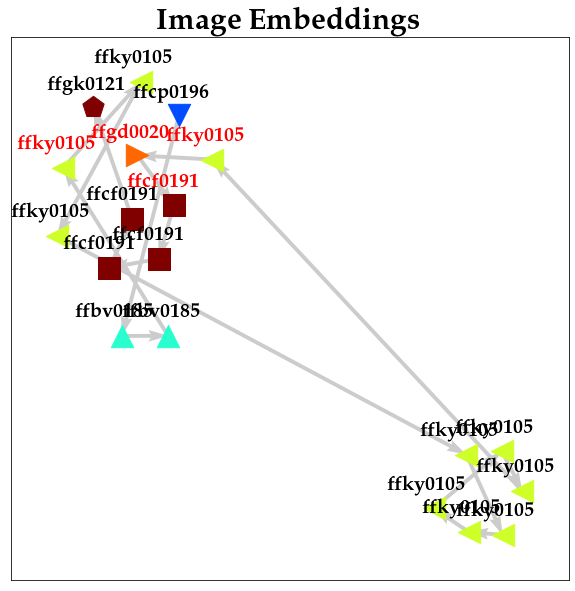

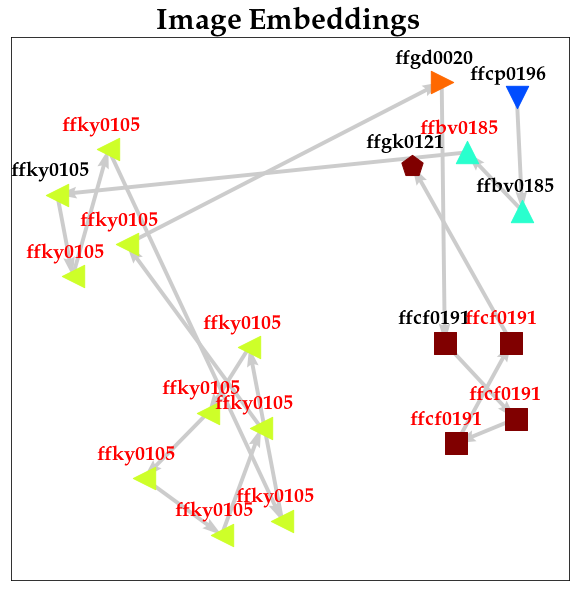

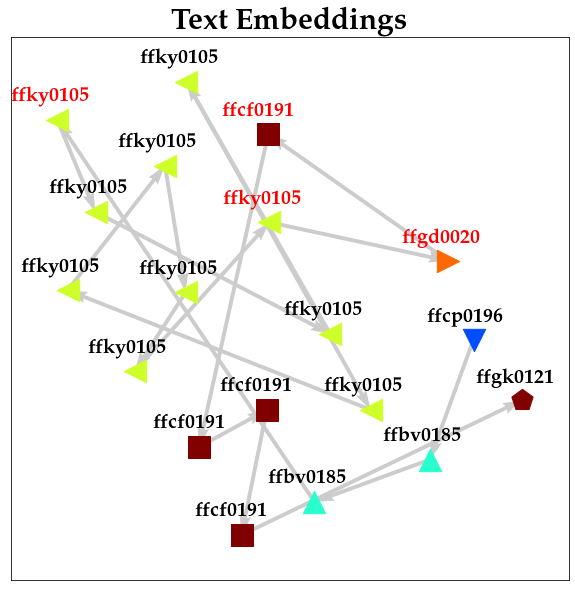

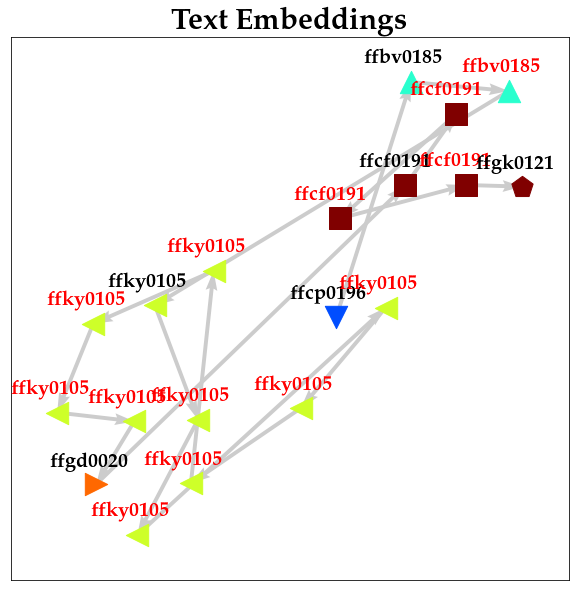

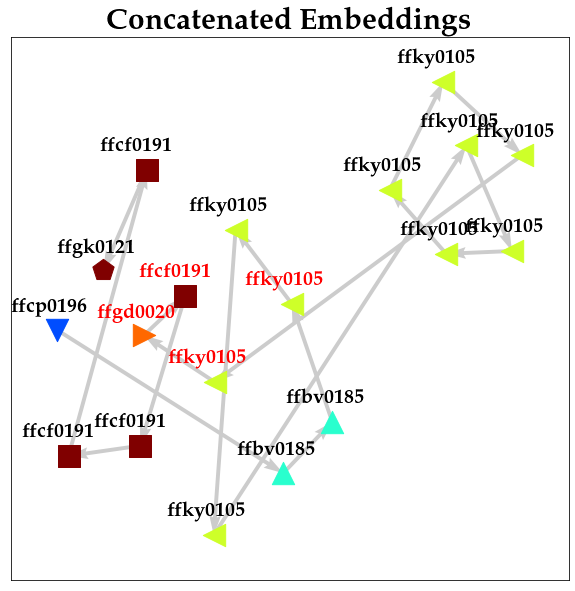

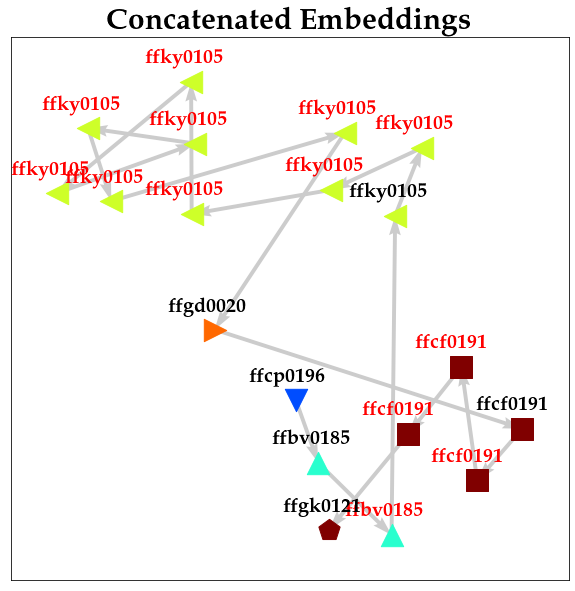

In [7]:
X_umap = umap.UMAP().fit_transform(embeddings[folder_id]['img'])
X_umap_untrained = umap.UMAP().fit_transform(embeddings_untrained[folder_id]['img'])

labels = np.array(all_labels[0])
predictions = np.argmax(outputs, axis=1)
plot(X_umap, labels, predictions, title=f"Image Embeddings", save_path="notebooks/figs/embed_img_train_incorrect.pdf")

predictions_untrained = np.argmax(outputs_untrained, axis=1)
plot(X_umap_untrained, labels, predictions_untrained, title= f"Image Embeddings", save_path="notebooks/figs/embed_img_untrain_incorrect.pdf")

X_umap = umap.UMAP().fit_transform(embeddings[folder_id]['ocr'])
X_umap_untrained = umap.UMAP().fit_transform(embeddings_untrained[folder_id]['ocr'])

labels = np.array(all_labels[0])
predictions = np.argmax(outputs, axis=1)
plot(X_umap, labels, predictions, title=f"Text Embeddings", save_path="notebooks/figs/embed_ocr_train_incorrect.pdf")

predictions_untrained = np.argmax(outputs_untrained, axis=1)
plot(X_umap_untrained, labels, predictions_untrained, title= f"Text Embeddings", save_path="notebooks/figs/embed_ocr_untrain_incorrect.pdf")

concat = torch.cat([embeddings[folder_id]['ocr'], embeddings[folder_id]['img']], 1)
concat_untrained = torch.cat([embeddings_untrained[folder_id]['ocr'], embeddings_untrained[folder_id]['img']], 1)
X_umap = umap.UMAP().fit_transform(concat)
X_umap_untrained = umap.UMAP().fit_transform(concat_untrained)

labels = np.array(all_labels[0])
predictions = np.argmax(outputs, axis=1)
plot(X_umap, labels, predictions, title=f"Concatenated Embeddings", save_path="notebooks/figs/embed_concat_train_incorrect.pdf")

predictions_untrained = np.argmax(outputs_untrained, axis=1)
plot(X_umap_untrained, labels, predictions_untrained, title= f"Concatenated Embeddings", save_path="notebooks/figs/embed_concat_untrain_incorrect.pdf")